In [3]:
import os 
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from skimage import segmentation, color, graph
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import networkx as nx

In [4]:
TRAIN_DATA_DIR = "data/train"
CLASS_DICT = "data/class_dict.csv"

class_df = pd.read_csv(CLASS_DICT)
class_rgb_values = class_df[['r', 'g', 'b']].values.tolist()
class_names = class_df['name'].tolist()
n_classes = len(class_names)

# original images are 2448x2448. we can use these constants to control their scaling.
IMG_HEIGHT, IMG_WIDTH = 512, 512

In [5]:
class DeepGlobeDataset(Dataset):
    def __init__(self, data_dir, class_rgb_values, img_size):
        self.image_paths = sorted(glob(os.path.join(data_dir, '*_sat.jpg')))
        self.mask_paths  = sorted(glob(os.path.join(data_dir, '*_mask.png')))
        self.class_rgb_values = class_rgb_values
        self.img_size = img_size  # (W, H)
        self.img_to_tensor = T.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # --- Load & resize image ---
        img = Image.open(self.image_paths[idx]).convert('RGB')
        img = img.resize(self.img_size, resample=Image.Resampling.BILINEAR)

        # --- Load & resize mask ---
        mask = Image.open(self.mask_paths[idx]).convert('RGB')
        mask = mask.resize(self.img_size, resample=Image.Resampling.NEAREST)

        img_t = self.img_to_tensor(img)   # float32, (3,H,W) in [0,1]

        mask_np = np.array(mask)                   # (H,W,3), uint8
        mask_np = self.rgb_to_class(mask_np)  # (H,W), uint8
        mask_t = torch.from_numpy(mask_np).long()  # (H,W), int64

        return img_t, mask_t
    
    def rgb_to_class(self, mask):
        """
        Convert (H, W, 3) RGB mask to (H, W) class-index mask.
        """
        semantic_map = np.zeros(mask.shape[:2], dtype=np.uint8)
        for idx, color in enumerate(self.class_rgb_values):
            semantic_map[np.all(mask == color, axis=-1)] = idx
        return semantic_map


In [6]:
dataset = DeepGlobeDataset(
    data_dir=TRAIN_DATA_DIR,
    class_rgb_values=class_rgb_values,
    img_size=(IMG_WIDTH, IMG_HEIGHT),
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=(device.type=="cuda"))


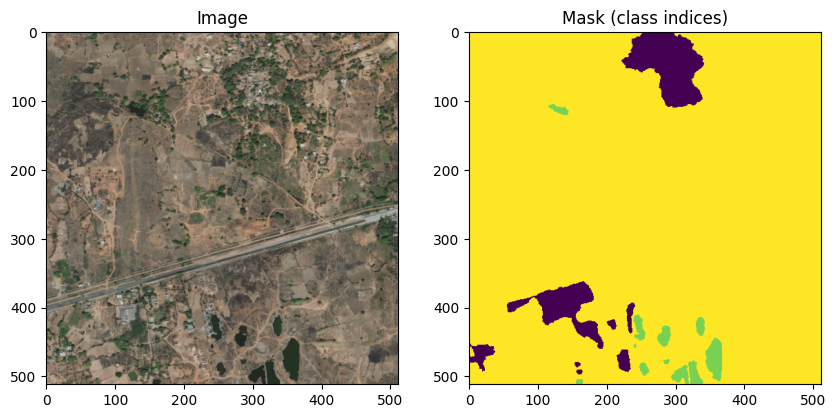

In [7]:
# example visualization 
images,masks = next(iter(loader))
img = images[0].permute(1, 2, 0).cpu().numpy()  # (H, W, 3)
mask = masks[0].cpu().numpy()                   # (H, W)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Image")


plt.subplot(1,2,2)
plt.imshow(mask)  # categorical mask
plt.title("Mask (class indices)")
plt.show()

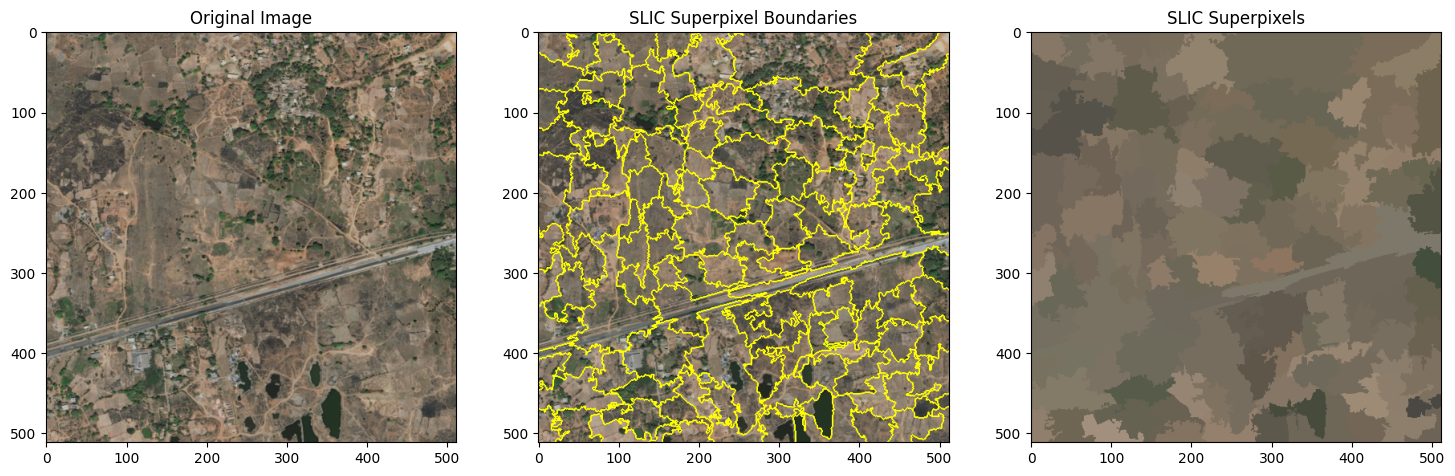

In [8]:
K = 200
segments = segmentation.slic(img, n_segments=K, compactness=10, start_label=1)
n_nodes = segments.max()

# Visualize SLIC result
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(img)
ax[0].set_title("Original Image")

ax[1].imshow(segmentation.mark_boundaries(img, segments))
ax[1].set_title("SLIC Superpixel Boundaries")

ax[2].imshow(color.label2rgb(segments, img, kind='avg'))
ax[2].set_title("SLIC Superpixels")

plt.show()

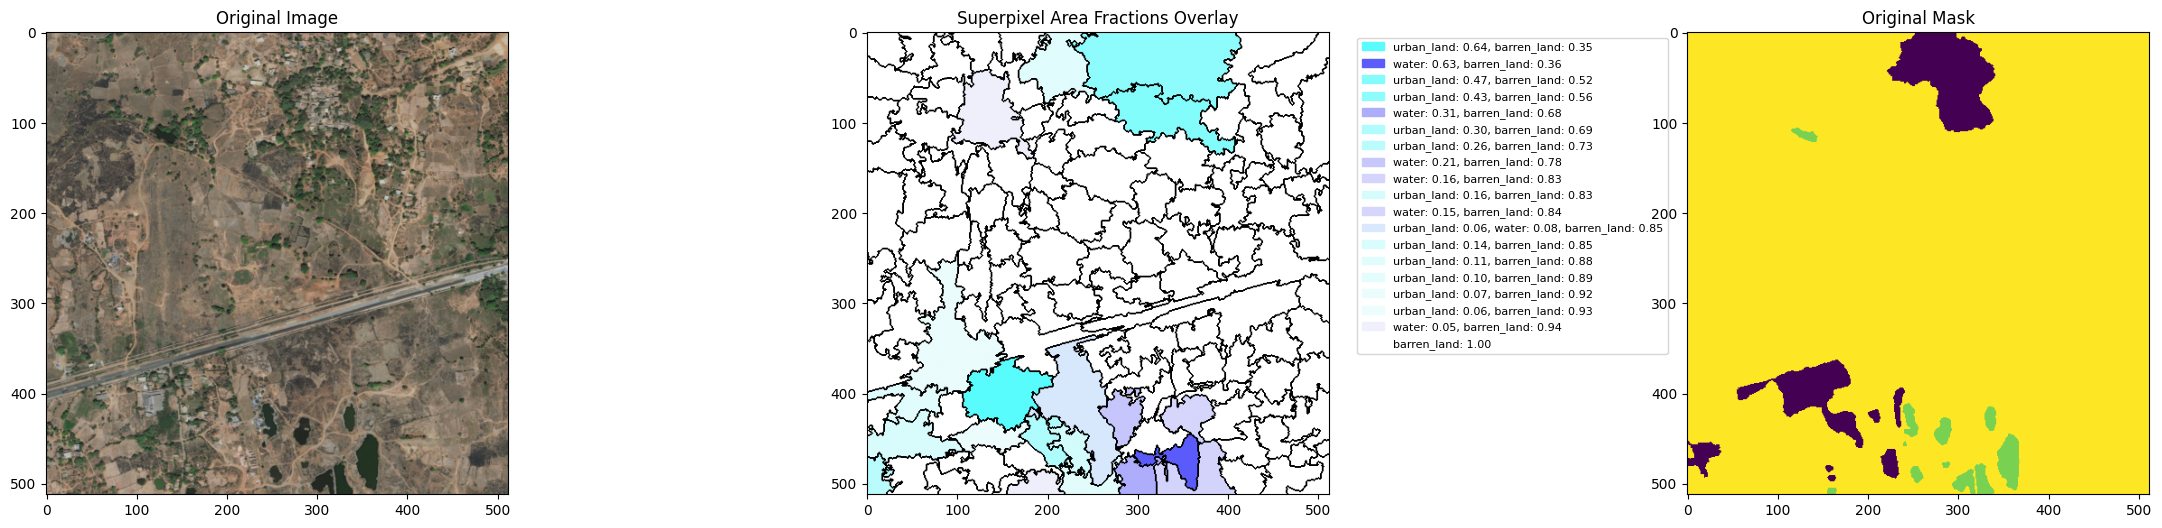

In [9]:
labels = np.zeros((n_nodes, n_classes), dtype=np.uint8)

# areas will hold the area (in pixels) of each class within each superpixel
areas = np.zeros((n_nodes, n_classes), dtype=np.int32)

for i in range(1, n_nodes + 1):
    region_mask = (segments == i)
    region_classes = mask[region_mask]
    unique, counts = np.unique(region_classes, return_counts=True)
    areas[i - 1, unique] = counts

# normalize areas 
region_sizes = areas.sum(axis=1, keepdims=True)
fractions = np.divide(
    areas, 
    region_sizes, 
    out=np.zeros_like(areas, dtype=float), 
    where=region_sizes != 0
)

fractions[fractions < 0.05] = 0.0
row_sums = fractions.sum(axis=1, keepdims=True)
fractions = np.divide(
    fractions,
    row_sums,
    out=np.zeros_like(fractions),
    where=row_sums != 0
)

fractions = np.floor(fractions * 100) / 100 # round down to 2 decimals
# Compute colors for superpixels
sp_colors = np.zeros((n_nodes, 3), dtype=np.float32)
sp_label_combos = []  # store class names for each superpixel
for i in range(n_nodes):
    present_classes = np.where(fractions[i] > 0)[0]
    sp_colors[i] = np.sum(
        np.array(class_rgb_values) * fractions[i, :, None],
        axis=0
    )
    label_names = [f"{class_names[c]}: {fractions[i, c]:.2f}" for c in present_classes]
    sp_label_combos.append(label_names)

# Create an image where each pixel gets its superpixel color
color_img = np.zeros_like(img, dtype=np.uint8)
for i in range(1, n_nodes + 1):
    color_img[segments == i] = sp_colors[i-1]


# Plot original image, mask, and superpixel labels
fig, ax = plt.subplots(1, 3, figsize=(30, 6))
ax[0].imshow(img)
ax[0].set_title("Original Image")

ax[1].imshow(segmentation.mark_boundaries(color_img, segments, (0, 0, 0)))
ax[1].set_title("Superpixel Area Fractions Overlay")

ax[2].imshow(mask)
ax[2].set_title("Original Mask")

# --- Add legend for superpixel colors ---
unique_colors, unique_indices = np.unique(sp_colors, axis=0, return_index=True)
patches = []
for idx in unique_indices:
    label_colors = sp_colors[idx] / 255  
    label_text = ", ".join(sp_label_combos[idx])
    patches.append(mpatches.Patch(color=label_colors, label=label_text))

ax[1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.show()

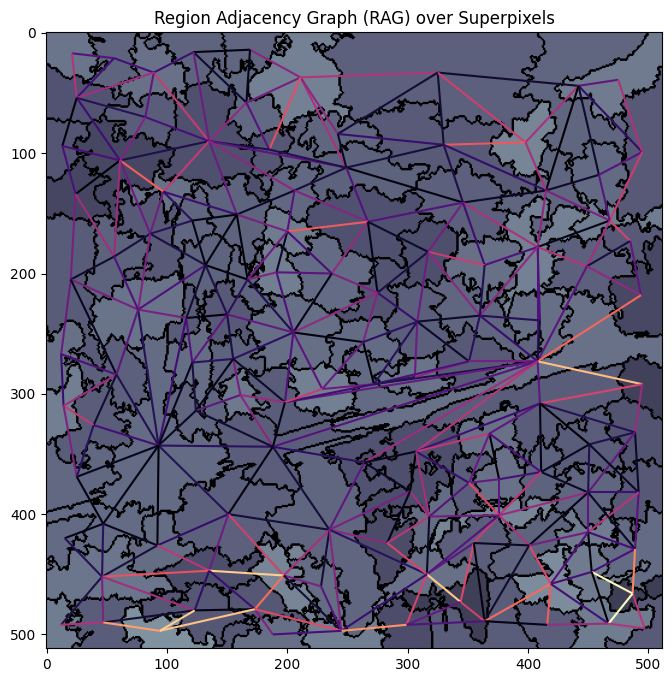

In [10]:
rag = graph.rag_mean_color(img, segments)
edges = np.array(list(rag.edges))

out = color.label2rgb(segments, img, kind='avg', bg_label=0)

# Draw RAG edges on top
fig, ax = plt.subplots(figsize=(8, 8))
graph.show_rag(segments, rag, out, ax=ax)
ax.set_title("Region Adjacency Graph (RAG) over Superpixels")
plt.show()

In [ ]:
# Collect undirected edges as pairs of 0-based indices
edges01 = []
weights = []  # optional: boundary weights if available
for n1, n2, attr in rag.edges(data=True):
    i, j = int(n1) - 1, int(n2) - 1  # convert label IDs to 0-based
    edges01.append((i, j))
    # Some RAGs carry 'count' (# boundary pixels) or 'weight'. Use if present.
    w = attr.get('count', 1.0)
    weights.append(float(w))

edges01 = np.array(edges01, dtype=int)
weights = np.array(weights, dtype=float)
if len(weights) == 0:  # fallback if nothing was stored
    weights = np.ones(len(edges01), dtype=float)

# 2) Similarity function for continuous labels
def cosine_sim(p, q):
    pn = np.linalg.norm(p); qn = np.linalg.norm(q)
    if pn == 0 or qn == 0:
        return 0.0
    return float(np.dot(p, q) / (pn * qn))

# 3) Compute global homophily (pick one similarity)
def global_homophily(fractions, edges, weights=None):
    sims = []
    for (i, j) in edges:
        s = cosine_sim(fractions[i], fractions[j])
        sims.append(s)
    sims = np.array(sims)
    if weights is not None:
        w = weights
        return float(np.average(sims, weights=w))
    return float(sims.mean())

H_global = global_homophily(fractions, edges01, weights)

print(f"Global homophily (cosine):     {H_global:.4f}")

# 4) Per-class homophily (1 - MAE over edges)
def per_class_homophily(fractions, edges, weights=None):
    n_classes = fractions.shape[1]
    Hc = np.zeros(n_classes, dtype=float)
    for c in range(n_classes):
        diffs = np.abs(fractions[edges[:,0], c] - fractions[edges[:,1], c])
        if weights is not None:
            mae = np.average(diffs, weights=weights)
        else:
            mae = diffs.mean()
        Hc[c] = 1.0 - mae  # in [0,1]
    return Hc

H_per_class = per_class_homophily(fractions, edges01, weights)
for c, h in enumerate(H_per_class):
    print(f"Class {c} homophily (1 - MAE): {h:.4f}")

# 5) Node-level homophily (average similarity to neighbors)
def node_homophily(fractions, edges, n_nodes):
    nbrs = [[] for _ in range(n_nodes)]
    for i, j in edges:
        nbrs[i].append(j)
        nbrs[j].append(i)
    node_scores = np.full(n_nodes, np.nan, dtype=float)
    for i in range(n_nodes):
        if not nbrs[i]:
            continue
        s_list = []
        for j in nbrs[i]:
            s = cosine_sim(fractions[i], fractions[j])
            s_list.append(s)
        node_scores[i] = float(np.mean(s_list))
    return node_scores

node_h  = node_homophily(fractions, edges01, n_nodes)

print("Per-node homophily computed. Example:", node_h[:10])



#6) average of the Jaccard similarity of the label
# set of all connected nodes in the graph
def label_homophily(labels, edges):

    jaccards = []
    for i, j in edges:
        li = labels[i].astype(bool)
        lj = labels[j].astype(bool)
        union = np.logical_or(li, lj).sum()
        if union == 0:
            continue
        inter = np.logical_and(li, lj).sum()
        jaccards.append(inter / union)
    if len(jaccards) == 0:
        return 0.0
    return float(np.mean(jaccards))


labels_bin = (fractions > 0).astype(int) 

label_H = label_homophily(labels_bin, edges01)
print(f"Label homophily (Jaccard): {label_H:.4f}")

def weighted_label_homophily(fractions, edges):
    jaccards = []
    for i, j in edges:
        fi = fractions[i]
        fj = fractions[j]

        inter = np.minimum(fi, fj).sum()
        union = np.maximum(fi, fj).sum()

        if union == 0:
            continue

        jaccards.append(inter / union)

    if len(jaccards) == 0:
        return 0.0
    return float(np.mean(jaccards))

weighted_label_H = weighted_label_homophily(fractions, edges01)
print(f"Weighted label homophily (Jaccard): {weighted_label_H:.4f}")

# 7) cross-class neighborhood similarity
def compute_neighborhood_distributions(labels, edges, n_nodes):
    n_classes = labels.shape[1]
    nbrs = [[] for _ in range(n_nodes)]
    for i, j in edges:
        nbrs[i].append(j)
        nbrs[j].append(i)

    d = np.zeros((n_nodes, n_classes), dtype=float)
    for i in range(n_nodes):
        if nbrs[i]:
            d[i] = labels[nbrs[i]].mean(axis=0)
    return d


def ccns_multi_label(labels, edges):
    n_nodes, n_classes = labels.shape
    d = compute_neighborhood_distributions(labels, edges, n_nodes)

    class_nodes = [np.where(labels[:, c] > 0)[0] for c in range(n_classes)]
    ccns = np.zeros((n_classes, n_classes), dtype=float)

    for c in range(n_classes):
        for cp in range(n_classes):
            nodes_c = class_nodes[c]
            nodes_cp = class_nodes[cp]

            sims = []
            for i in nodes_c:
                for j in nodes_cp:
                    if i == j:
                        continue
                    sims.append(cosine_sim(d[i], d[j]))
            if sims:
                ccns[c, cp] = np.mean(sims)
            else:
                ccns[c, cp] = 0.0 
    return ccns

CCNS = ccns_multi_label(labels_bin, edges01)
print("CCNS matrix:")
print(np.array2string(np.round(CCNS, 3), formatter={'float_kind':lambda x: f"{x:.3f}"}))
diag = np.diag(CCNS)
print("\nDiagonal (intra-class neighborhood similarity):")
for c, val in enumerate(diag):
    print(f"Class {c} ({class_names[c]}): {val:.3f}")

Global homophily (cosine):     0.9771
Class 0 homophily (1 - MAE): 0.9608
Class 1 homophily (1 - MAE): 1.0000
Class 2 homophily (1 - MAE): 1.0000
Class 3 homophily (1 - MAE): 1.0000
Class 4 homophily (1 - MAE): 0.9819
Class 5 homophily (1 - MAE): 0.9438
Class 6 homophily (1 - MAE): 1.0000
Per-node homophily computed. Example: [1.         1.         0.99971767 0.99964708 0.99742596 0.9706592
 0.84776197 0.96552504 1.         0.99817324]
Label homophily (Jaccard): 0.8849
Weighted label homophily (Jaccard): 0.9131
CCNS matrix:
[[0.951 0.000 0.000 0.000 0.889 0.907 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.889 0.000 0.000 0.000 0.910 0.907 0.000]
 [0.907 0.000 0.000 0.000 0.907 0.944 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000]]

Diagonal (intra-class neighborhood similarity):
Class 0 (urban_land): 0.951
Class 1 (agriculture_land): 0.000
Class 2 (rangeland): 0.000
Class 3 (forest_

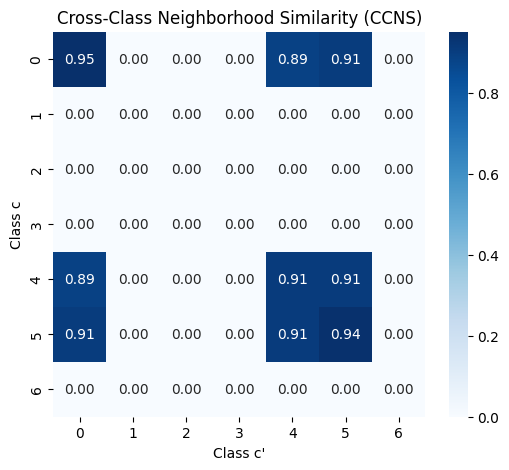

In [12]:
CCNS = np.nan_to_num(CCNS, nan=0.0) 

plt.figure(figsize=(6,5))
sns.heatmap(CCNS, annot=True, cmap="Blues", fmt=".2f")
plt.xlabel("Class c'")
plt.ylabel("Class c")
plt.title("Cross-Class Neighborhood Similarity (CCNS)")
plt.show()

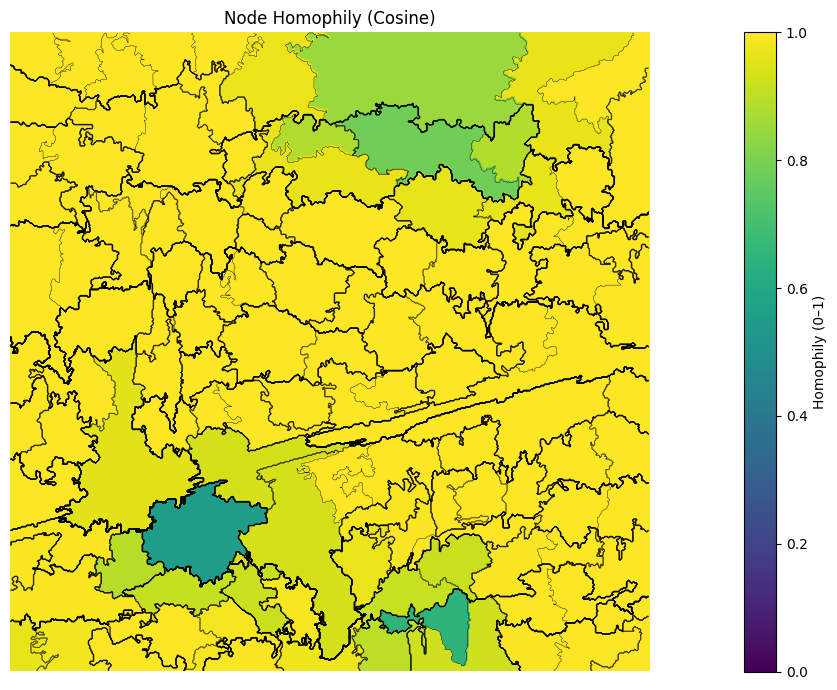

In [13]:
scores = node_h
scores = np.nan_to_num(scores, nan=0.0)              # if some nodes have no neighbors

# Clip to [0,1] for safety and normalize for colormap
scores = np.clip(scores, 0.0, 1.0)

# Build a per-pixel heatmap image: map each superpixel to its score
hom_img = np.zeros(segments.shape, dtype=float)
for sid in range(1, n_nodes + 1):
    hom_img[segments == sid] = scores[sid - 1]

# Plot: homophily heatmap overlay
fig, ax = plt.subplots(1, 1, figsize=(24, 7))

im = ax.imshow(hom_img, cmap='viridis', vmin=0.0, vmax=1.0)
ax.contour(segments, levels=np.unique(segments).shape[0], colors='k', linewidths=0.3)
ax.set_title(f"Node Homophily (Cosine)")
ax.axis('off')
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Homophily (0–1)')

plt.tight_layout()
plt.show()

In [14]:
def compute_metrics_image(img, mask, class_rgb_values, n_segments=200):
    segments = segmentation.slic(img, n_segments=n_segments, compactness=10, start_label=1)
    n_nodes = segments.max()

    n_classes = len(class_rgb_values)
    areas = np.zeros((n_nodes, n_classes), dtype=np.int32)
    for i in range(1, n_nodes + 1):
        region_mask = (segments == i)
        region_classes = mask[region_mask]
        unique, counts = np.unique(region_classes, return_counts=True)
        areas[i - 1, unique] = counts

    region_sizes = areas.sum(axis=1, keepdims=True)
    fractions = np.divide(
        areas, 
        region_sizes, 
        out=np.zeros_like(areas, dtype=float), 
        where=region_sizes != 0
    )
    fractions[fractions < 0.05] = 0.0
    row_sums = fractions.sum(axis=1, keepdims=True)
    fractions = np.divide(
        fractions,
        row_sums,
        out=np.zeros_like(fractions),
        where=row_sums != 0
    )

    rag = graph.rag_mean_color(img, segments)
    edges = np.array(list(rag.edges))
    edges01 = np.array([(int(i)-1, int(j)-1) for i, j in edges], dtype=int)

    labels_bin = (fractions > 0).astype(int)

    r_homo = label_homophily(labels_bin, edges01)
    r_homo_weighted = weighted_label_homophily(fractions, edges01)

    G = nx.Graph()
    G.add_nodes_from(range(n_nodes))
    G.add_edges_from(edges01)
    clustering = np.mean(list(nx.clustering(G).values())) if G.number_of_nodes() > 1 else 0.0

    return {
        "n_nodes": n_nodes,
        "n_edges": len(edges01),
        "clustering": clustering,
        "r_homo": r_homo, 
        "r_homo_weighted": r_homo_weighted
    }



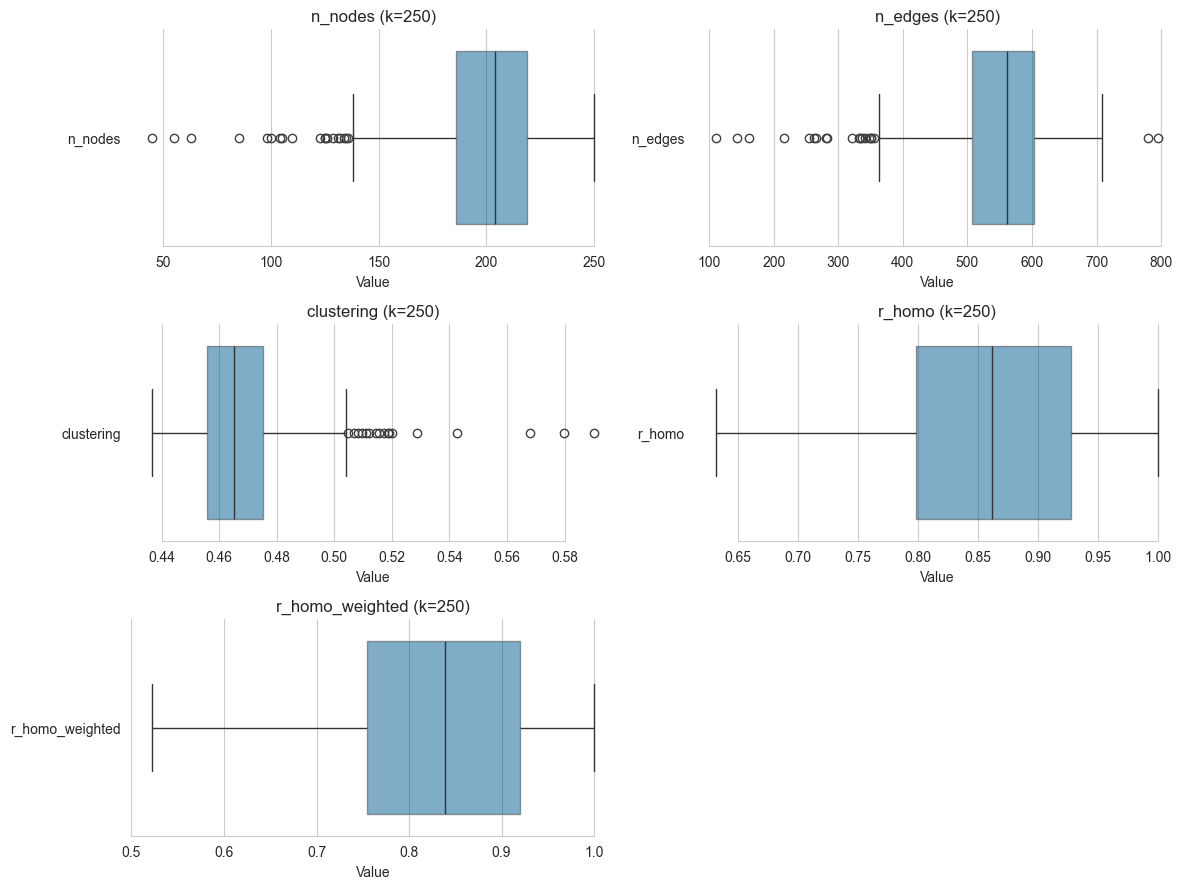

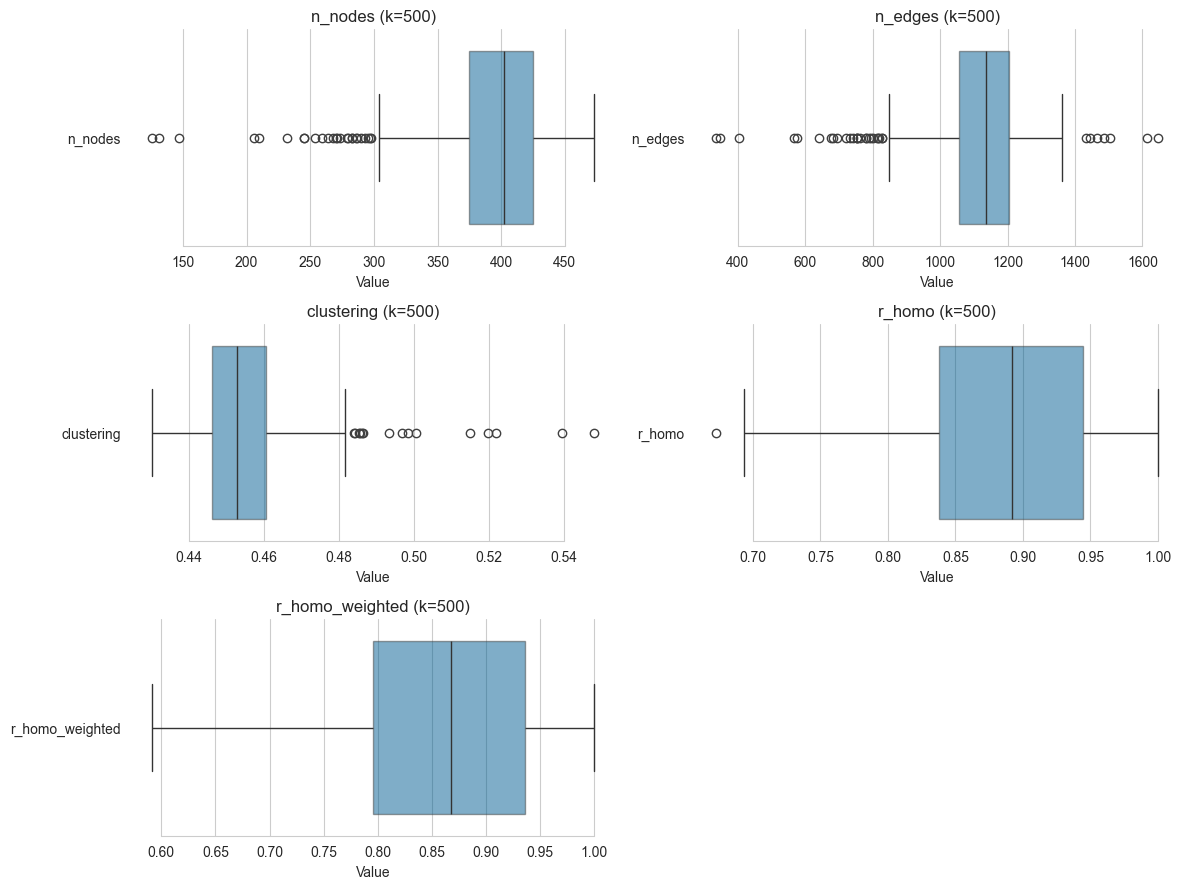

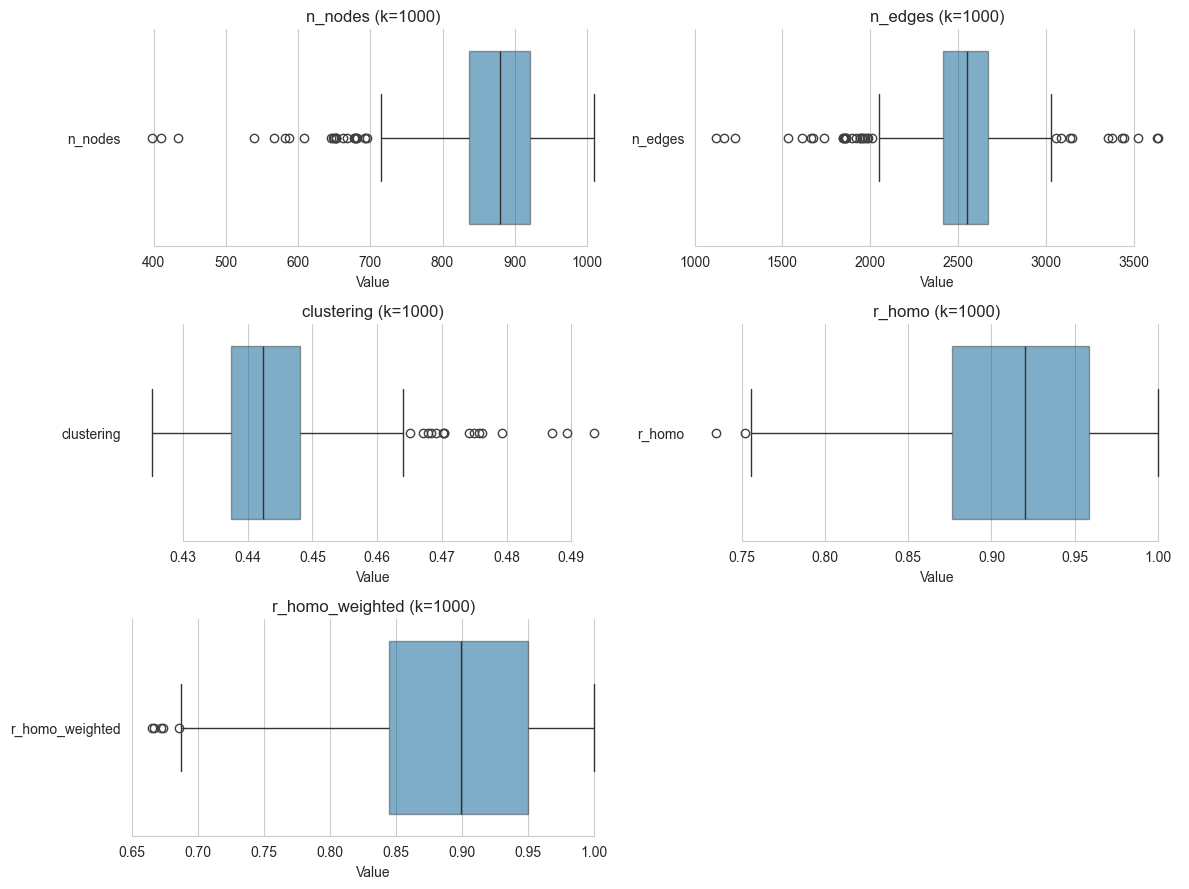

,n_nodes,n_edges,clustering,r_homo,r_homo_weighted,image_index,k
0,228,631,0.462267,0.923138,0.910042,0,250
1,230,630,0.461535,0.966667,0.967596,1,250
2,216,594,0.490480,0.954826,0.983526,2,250
3,220,608,0.469538,0.941338,0.926734,3,250
4,191,523,0.466765,0.856915,0.801484,4,250


metrics per k (avg):


,k,n_nodes,n_edges,clustering,r_homo,r_homo_weighted
0,250,200.011208,549.357410,0.467076,0.857630,0.828865
1,500,395.353674,1119.129514,0.453896,0.885230,0.858058
2,1000,870.863014,2529.821918,0.443243,0.912091,0.889190


In [15]:
all_metrics = []
num_images = len(dataset)

ks = [250, 500, 1000]

# for k in ks:
#     print(f"\nprocessing dataset for k={k}")

#     for i in range(num_images):
#         print(f"image {i+1}/{num_images} | k={k} ...", end="\r")
#         img_t, mask_t = dataset[i]
#         img = img_t.permute(1, 2, 0).numpy()
#         mask = mask_t.numpy()

#         metrics = compute_metrics_image(img, mask, class_rgb_values, n_segments=k)
#         metrics.update({"image_index": i, "k": k})
#         all_metrics.append(metrics)

# print("\nDone processing all images")

# metrics_df = pd.DataFrame(all_metrics)

# summary_df = metrics_df.groupby("k")[["n_nodes", "n_edges", "clustering", "r_homo", "r_homo_weighted"]].mean().reset_index()
# summary_df.index = summary_df["k"]
# summary_df = summary_df.drop(columns="k")

# metrics_df.to_csv("dataset_metrics_per_image_k.csv", index=False)
# summary_df.to_csv("dataset_metrics_summary_k.csv")

sns.set_style("whitegrid")

metrics_df = pd.read_csv("dataset_metrics_per_image_k.csv")
summary_df = pd.read_csv("dataset_metrics_summary_k.csv")

sns.set_style("whitegrid")

size_metrics = ["n_nodes", "n_edges"]
clust_homo_metrics = ["clustering", "r_homo", "r_homo_weighted"]
all_metrics_list = size_metrics + clust_homo_metrics

ks = sorted(metrics_df["k"].unique())

for k in ks:
    subset = metrics_df[metrics_df["k"] == k]
    
    n_metrics = len(all_metrics_list)
    n_cols = 2
    n_rows = (n_metrics + 1) // n_cols 
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows*3))
    axes = axes.flatten()
    
    box_color = "#333333"
    point_color = "#333333"
    
    for i, metric in enumerate(all_metrics_list):
        sns.boxplot(
            data=subset[[metric]],
            orient='h',
            boxprops=dict(facecolor="#005D92", alpha=0.5),
            whiskerprops=dict(color="#333333"),
            capprops=dict(color="#333333"),
            medianprops=dict(color="#333333"),
            ax=axes[i]
        )
        
        
        axes[i].set_title(f"{metric} (k={k})", fontsize=12)
        axes[i].set_xlabel("Value", fontsize=10)
        sns.despine(trim=True, ax=axes[i])
    
    for j in range(len(all_metrics_list), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

display(metrics_df.head())

print("metrics per k (avg):")
display(summary_df)